In [1]:
import pandas as pd
from pandas.api import types

import bamboolib as bam
import mitosheet

import numpy as np

import seaborn as sns

from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans

import statsmodels.api as sm
import pylab as py

import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data\german\german_credit_data.csv', sep=',')
df = df.iloc[:,1:]
df

     Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0     67    male    2     own             NaN           little           1169   
1     22  female    2     own          little         moderate           5951   
2     49    male    1     own          little              NaN           2096   
3     45    male    2    free          little           little           7882   
4     53    male    2    free          little           little           4870   
..   ...     ...  ...     ...             ...              ...            ...   
995   31  female    1     own          little              NaN           1736   
996   40    male    3     own          little           little           3857   
997   38    male    2     own          little              NaN            804   
998   23    male    2    free          little           little           1845   
999   27    male    2     own        moderate         moderate           4576   

     Duration              

In [3]:
data = df.copy()

In [4]:
data.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [5]:
data['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [6]:
data['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

In [7]:
#fill in the null values with the most frequent values
#for numerical we can use sklearn imputer (for numerical) and sklearn_pandas (for categorical)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
data[['Saving accounts', 'Checking account']] = imputer.fit_transform(data[['Saving accounts', 'Checking account']])

In [8]:
data.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

In [9]:
data.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object

In [10]:
numerical_features = []
categorical_features = []
for col in data.columns:
    if types.is_numeric_dtype(data[col].dtypes):
        numerical_features.append(col)
    else:
        categorical_features.append(col)

print(numerical_features)
print(categorical_features)

['Age', 'Job', 'Credit amount', 'Duration']
['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


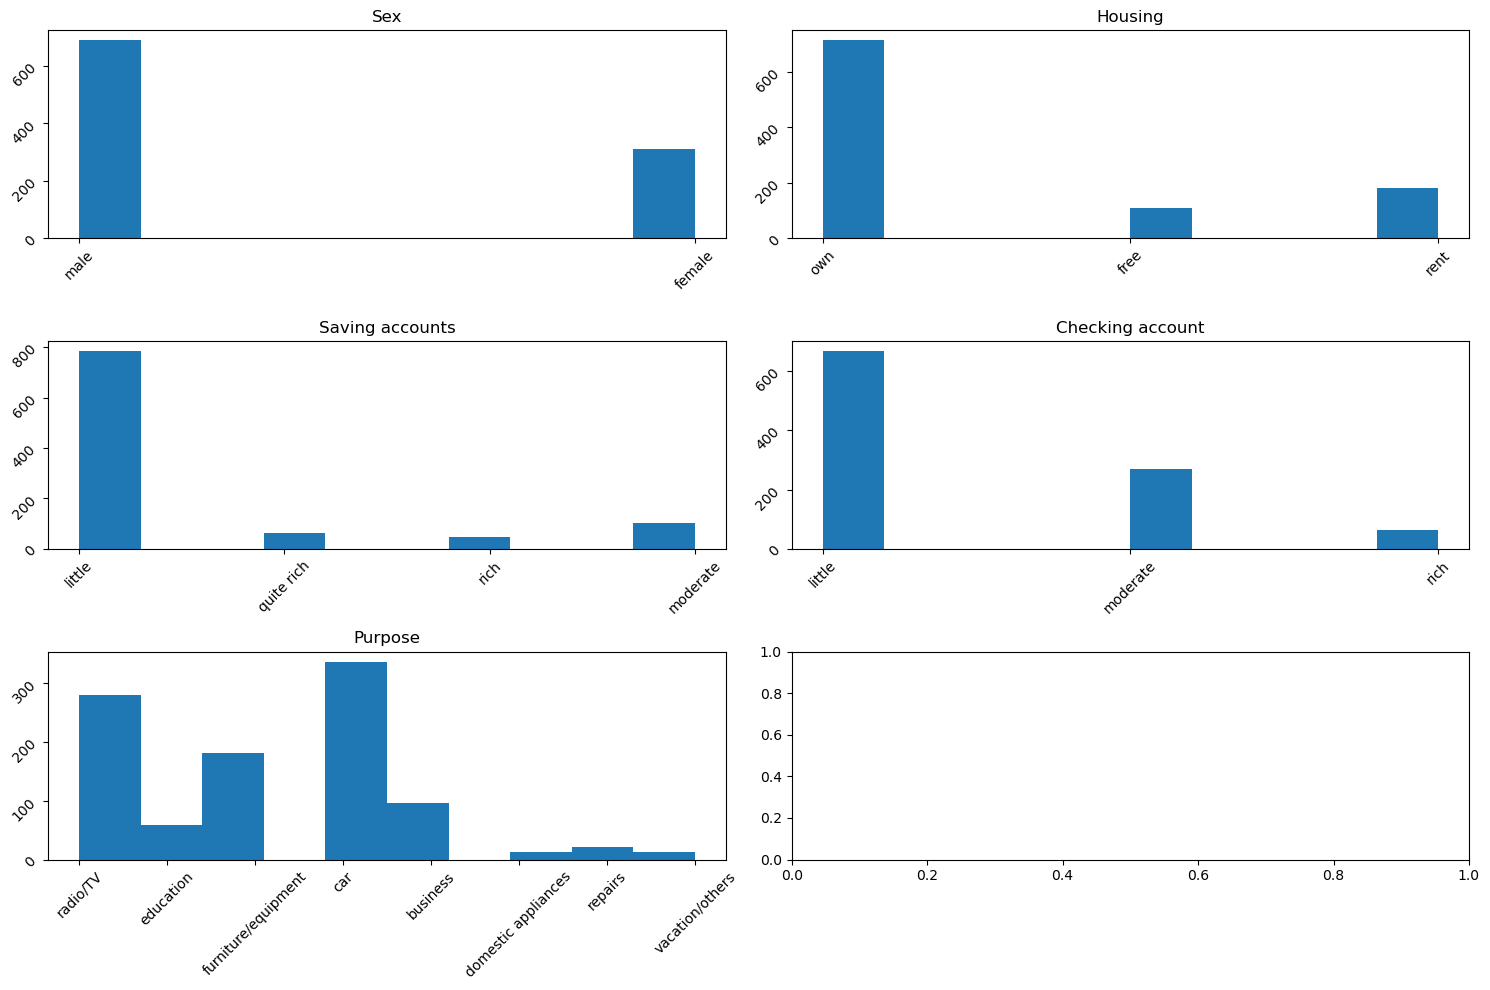

In [11]:
#plot categorical values
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for ax, feat in zip(axes.flatten(), categorical_features):
    ax.hist(data[feat], align='mid')
    ax.set_title(feat)
    ax.tick_params(rotation=45)
plt.tight_layout()

In [12]:
data

     Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0     67    male    2     own          little           little           1169   
1     22  female    2     own          little         moderate           5951   
2     49    male    1     own          little           little           2096   
3     45    male    2    free          little           little           7882   
4     53    male    2    free          little           little           4870   
..   ...     ...  ...     ...             ...              ...            ...   
995   31  female    1     own          little           little           1736   
996   40    male    3     own          little           little           3857   
997   38    male    2     own          little           little            804   
998   23    male    2    free          little           little           1845   
999   27    male    2     own        moderate         moderate           4576   

     Duration              

In [13]:
import pandas as pd; import numpy as np
# Step: Group by and aggregate
house_by_sex = data.groupby(['Housing', 'Sex']).agg(Housing_size=('Housing', 'size')).reset_index()

house_by_sex

  Housing     Sex  Housing_size
0    free  female            19
1    free    male            89
2     own  female           196
3     own    male           517
4    rent  female            95
5    rent    male            84

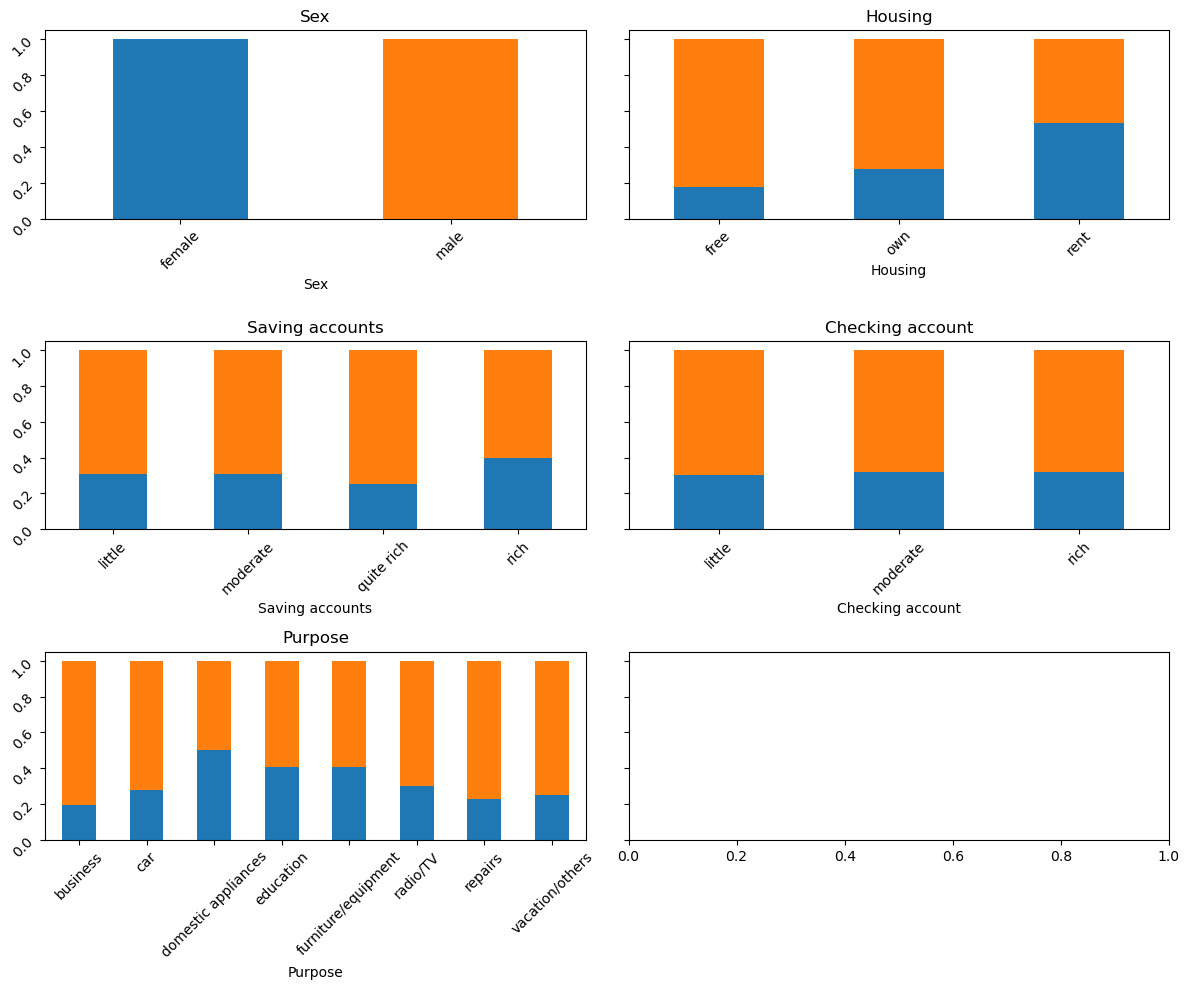

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(12,10), sharey=True)

for ax,feat in zip(axs.flatten(),categorical_features):
    ((pd.crosstab(data['Sex'], data[feat])) / (pd.crosstab(data['Sex'], data[feat]).sum())).T.plot.bar(stacked=True,ax=ax,legend=False,title=None)
    ax.set_title(feat)
    ax.tick_params(rotation=45)
plt.tight_layout()

In [15]:
#checking numerical features
data[numerical_features][:5]

   Age  Job  Credit amount  Duration
0   67    2           1169         6
1   22    2           5951        48
2   49    1           2096        12
3   45    2           7882        42
4   53    2           4870        24

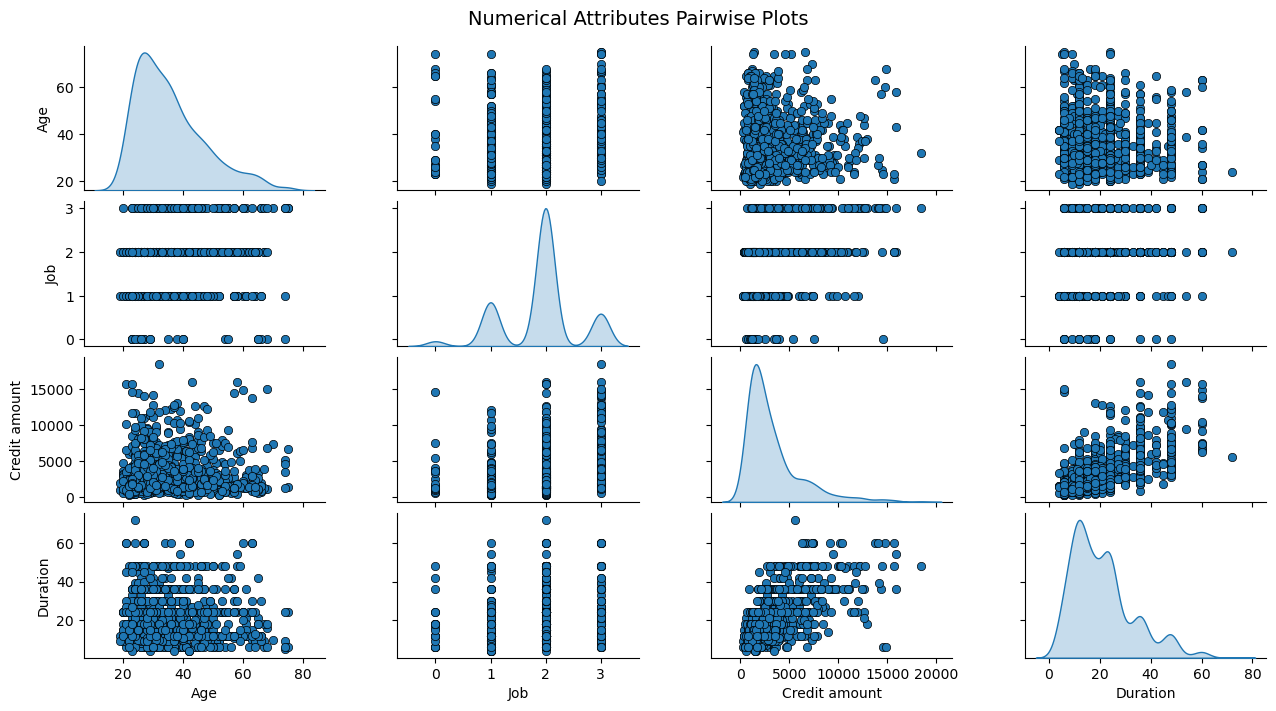

In [16]:
#check the distribution
pp = sns.pairplot(data[numerical_features], height=1.8, aspect=1.8, plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Numerical Attributes Pairwise Plots', fontsize=14)

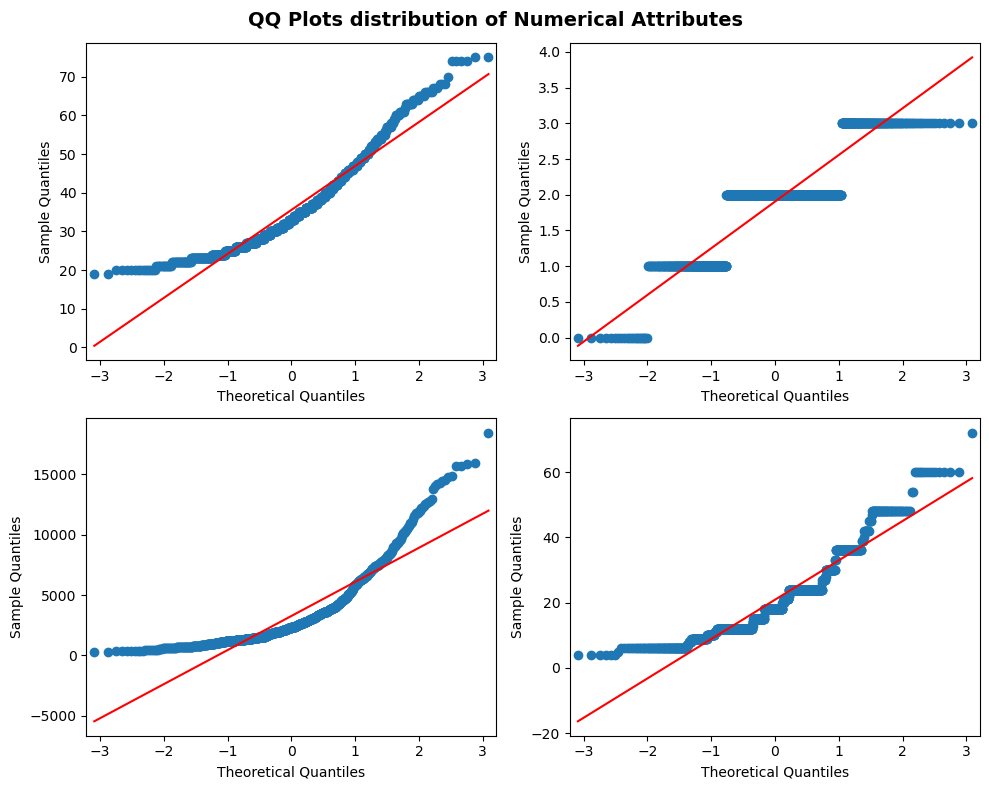

In [17]:
figure, axes = plt.subplots(2, 2, figsize=(10,8))
sm.qqplot(data[numerical_features[0]], line='s', ax = axes[0, 0])
sm.qqplot(data[numerical_features[1]], line='s', ax = axes[0, 1])
sm.qqplot(data[numerical_features[2]], line='s', ax = axes[1, 0])
sm.qqplot(data[numerical_features[3]], line='s', ax = axes[1, 1])
figure.suptitle('QQ Plots distribution of Numerical Attributes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### Best practice for Normalization vs Standardizedization
- Normalization is used when the data doesn't have Gaussian distribution whereas Standardization is used on data having Gaussian distribution.
- Normalization scales in a range of [0,1] or [-1,1]. Standardization is not bounded by range.
- Normalization is highly affected by outliers. Standardization is slightly affected by outliers.
- Normalization is considered when the algorithms do not make assumptions about the data distribution. Standardization is used when algorithms make assumptions about the data distribution.

In [18]:
from sklearn.preprocessing import scale, RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder

#from the QQ-plot, it shows that the numerical attributes do not follow normal distribution
#perform normalization to the numerical attributes
mm_scaler = MinMaxScaler()
# transform data
numerical_data = pd.DataFrame(mm_scaler.fit_transform(data[numerical_features]), columns=numerical_features)
numerical_data

          Age       Job  Credit amount  Duration
0    0.857143  0.666667       0.050567  0.029412
1    0.053571  0.666667       0.313690  0.647059
2    0.535714  0.333333       0.101574  0.117647
3    0.464286  0.666667       0.419941  0.558824
4    0.607143  0.666667       0.254209  0.294118
..        ...       ...            ...       ...
995  0.214286  0.333333       0.081765  0.117647
996  0.375000  1.000000       0.198470  0.382353
997  0.339286  0.666667       0.030483  0.117647
998  0.071429  0.666667       0.087763  0.602941
999  0.142857  0.666667       0.238032  0.602941

[1000 rows x 4 columns]

In [19]:
#check whether they're ordinal or nominal
for i in categorical_features:
    print(f'{i} ==============> {data[i].unique()}')

Sex ==============> ['male' 'female']
Housing ==============> ['own' 'free' 'rent']
Saving accounts ==============> ['little' 'quite rich' 'rich' 'moderate']
Checking account ==============> ['little' 'moderate' 'rich']
Purpose ==============> ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


In [20]:
#from the above, it is reasonable to treat Saving/Checking accounts as ordinal, and the rest as nominal
#perform mapping and convert categorical to numerical value
scaled_1 = data['Saving accounts'].map({'little':0, 'moderate':1, 'quite rich':2,'rich':3})
scaled_2 = data['Checking account'].map({'little':0, 'moderate':1, 'rich':2})
ordinal_data = pd.concat([scaled_1, scaled_2], axis=1)
ordinal_data

     Saving accounts  Checking account
0                  0                 0
1                  0                 1
2                  0                 0
3                  0                 0
4                  0                 0
..               ...               ...
995                0                 0
996                0                 0
997                0                 0
998                0                 0
999                1                 1

[1000 rows x 2 columns]

In [21]:
#apply Min Max scaler for ordinal attributes
ordinal_features = ['Saving accounts', 'Checking account']
ordinal_data = pd.DataFrame(mm_scaler.fit_transform(ordinal_data), columns=ordinal_features)
ordinal_data

     Saving accounts  Checking account
0           0.000000               0.0
1           0.000000               0.5
2           0.000000               0.0
3           0.000000               0.0
4           0.000000               0.0
..               ...               ...
995         0.000000               0.0
996         0.000000               0.0
997         0.000000               0.0
998         0.000000               0.0
999         0.333333               0.5

[1000 rows x 2 columns]

In [22]:
nominal_features = [c for c in categorical_features if c not in ordinal_features]
nominal_features

['Sex', 'Housing', 'Purpose']

In [23]:
#for non-ordering nominal attributes, perform one-hot encoding (do not scale as it is already either 0 or 1)
nominal_data = list()
for i,x in data[nominal_features].nunique().iteritems():
    nominal_data.append(pd.get_dummies(data[[i]],drop_first=True))
        
nominal_data = pd.concat(nominal_data,axis=1)
nominal_data

     Sex_male  Housing_own  Housing_rent  Purpose_car  \
0           1            1             0            0   
1           0            1             0            0   
2           1            1             0            0   
3           1            0             0            0   
4           1            0             0            1   
..        ...          ...           ...          ...   
995         0            1             0            0   
996         1            1             0            1   
997         1            1             0            0   
998         1            0             0            0   
999         1            1             0            1   

     Purpose_domestic appliances  Purpose_education  \
0                              0                  0   
1                              0                  0   
2                              0                  1   
3                              0                  0   
4                              0        

In [24]:
data_scaled = pd.concat([numerical_data, nominal_data, ordinal_data], axis=1)
data_orig = data[numerical_features+nominal_features+ordinal_features].copy()

In [25]:
data_scaled

          Age       Job  Credit amount  Duration  Sex_male  Housing_own  \
0    0.857143  0.666667       0.050567  0.029412         1            1   
1    0.053571  0.666667       0.313690  0.647059         0            1   
2    0.535714  0.333333       0.101574  0.117647         1            1   
3    0.464286  0.666667       0.419941  0.558824         1            0   
4    0.607143  0.666667       0.254209  0.294118         1            0   
..        ...       ...            ...       ...       ...          ...   
995  0.214286  0.333333       0.081765  0.117647         0            1   
996  0.375000  1.000000       0.198470  0.382353         1            1   
997  0.339286  0.666667       0.030483  0.117647         1            1   
998  0.071429  0.666667       0.087763  0.602941         1            0   
999  0.142857  0.666667       0.238032  0.602941         1            1   

     Housing_rent  Purpose_car  Purpose_domestic appliances  \
0               0            0      

['Age', 'Job', 'Credit amount', 'Duration', 'Sex_male', 'Housing_own', 'Housing_rent', 'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs', 'Purpose_vacation/others', 'Saving accounts', 'Checking account']
===============>cols:['Age', 'Job', 'Credit amount', 'Duration', 'Sex_male', 'Housing_own', 'Housing_rent', 'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs', 'Purpose_vacation/others', 'Saving accounts', 'Checking account']
[0.6330780750094751]
[0.6330780750094751, 0.8078347315733111]
[0.6330780750094751, 0.8078347315733111, 0.7223306934015296]
[0.6330780750094751, 0.8078347315733111, 0.7223306934015296, 0.6587773073265007]
[0.6330780750094751, 0.8078347315733111, 0.7223306934015296, 0.6587773073265007, 1.0]
[0.6330780750094751, 0.8078347315733111, 0.7223306934015296, 0.6587773073265007, 1.0, 1.0]
[0.633078075009475

[0.5846614180479949, 0.9701357466063351, 0.6568505336095075, 0.6473003880451306, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9587636363636363]
[0.5846614180479949, 0.9701357466063351, 0.6568505336095075, 0.6473003880451306, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9587636363636363, 1.0]
===============>cols:['Age', 'Job', 'Credit amount', 'Duration', 'Housing_rent', 'Purpose_car', 'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs', 'Saving accounts', 'Checking account']
[0.6686228723804383]
[0.6686228723804383, 0.8107802375917802]
[0.6686228723804383, 0.8107802375917802, 0.7539263540349996]
[0.6686228723804383, 0.8107802375917802, 0.7539263540349996, 0.6824737479428684]
[0.6686228723804383, 0.8107802375917802, 0.7539263540349996, 0.6824737479428684, 1.0]
[0.6686228723804383, 0.8107802375917802, 0.7539263540349996, 0.6824737479428684, 1.0, 0.8605454545454544]
[0.6686228723804383, 0.8107802375917802, 0.7539263540349996, 0.6824737479428684, 1.0, 0.8605454545454

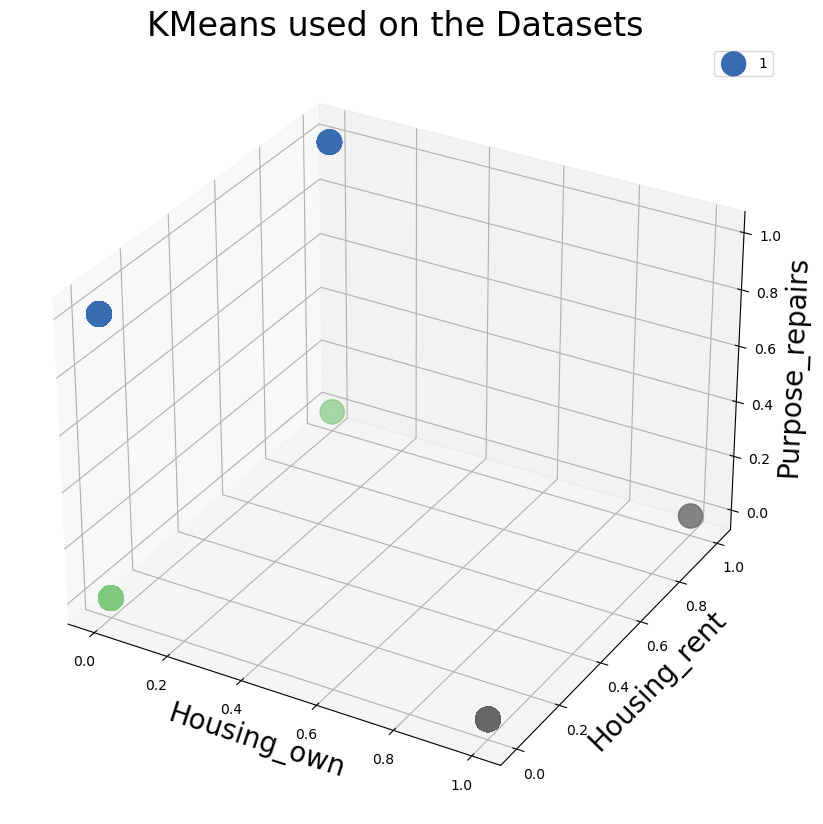

In [26]:
maxvars = 3
kmin = 2
kmax = 5
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 1500,"random_state": 0}
cut_off = 0.5

dt = data_scaled.copy()
cols = list(dt.columns)
print(cols)

results_of_k = []
vars_of_k = {}

for k in range(kmin, kmax+1):
    sel_vars = []
    while (len(sel_vars) < maxvars and len(cols) > 0):
        print(f'===============>cols:{cols}')
        results = []
        for col in cols:
            sel_cols = []
            sel_cols.extend(sel_vars)
            sel_cols.append(col)
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit_predict(dt[sel_cols])
            results.append(silhouette_score(dt[sel_cols], kmeans.labels_))
            print(results)
        sel_var=cols[np.argmax(results)]
        sel_vars.append(sel_var)
        cols.remove(sel_var)
    if (len(results) > 0):
        score = max(results)
        print(f'score:{score}: k:{k}')
        results_of_k.append(score)
        vars_of_k[k]=sel_vars
    
best_k=np.argmax(results_of_k)+kmin
selected_variables=vars_of_k[best_k]
kmeans = KMeans(n_clusters=best_k, **kmeans_kwargs)
kmeans.fit(dt[selected_variables])
clusters=kmeans.predict(dt[selected_variables])

print(f'best_k:{best_k}')

%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
z_points = dt[selected_variables[0]]
x_points = dt[selected_variables[1]]
y_points = dt[selected_variables[2]]
f1=ax.scatter3D(x_points, y_points, z_points, c=clusters,cmap='Accent',s=300);

ax.set_xlabel(selected_variables[0],fontsize = 20)
ax.set_ylabel(selected_variables[1],fontsize = 20)
ax.set_zlabel(selected_variables[2],fontsize = 20)
ax.legend(clusters)

plt.title('KMeans used on the Datasets',fontsize = 24)
plt.show()

['Age', 'Job', 'Credit amount', 'Duration', 'Sex_male']
===============>cols:['Age', 'Job', 'Credit amount', 'Duration', 'Sex_male']
[0.6330780750094751]
[0.6330780750094751, 0.8078347315733111]
[0.6330780750094751, 0.8078347315733111, 0.7223306934015296]
[0.6330780750094751, 0.8078347315733111, 0.7223306934015296, 0.6587773073265007]
[0.6330780750094751, 0.8078347315733111, 0.7223306934015296, 0.6587773073265007, 1.0]
===============>cols:['Age', 'Job', 'Credit amount', 'Duration']
[0.7944722515662004]
[0.7944722515662004, 0.7988694660873731]
[0.7944722515662004, 0.7988694660873731, 0.853570276068599]
[0.7944722515662004, 0.7988694660873731, 0.853570276068599, 0.8168234396633115]
===============>cols:['Age', 'Job', 'Duration']
[0.7217672682704942]
[0.7217672682704942, 0.7166111500800996]
[0.7217672682704942, 0.7166111500800996, 0.7508362198529339]
score:0.7508362198529339: k:2
===============>cols:['Age', 'Job']
[0.5846614180479949]
[0.5846614180479949, 0.9701357466063351]
===========

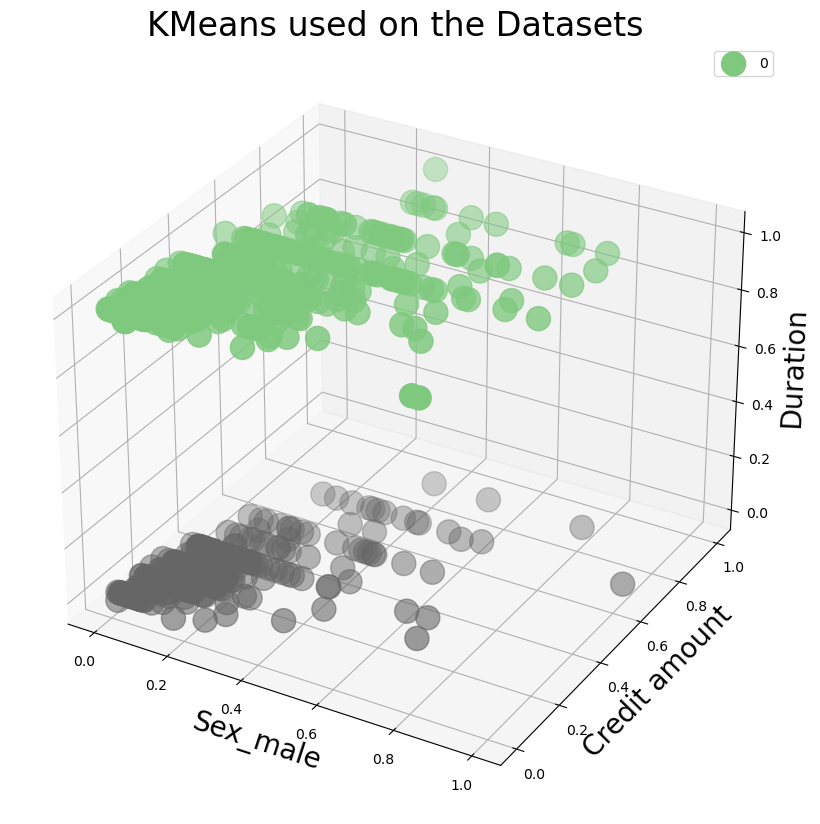

In [27]:
maxvars = 3
kmin = 2
kmax = 5
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 1500,"random_state": 0}
cut_off = 0.5

dt = data_scaled.iloc[:,:5] #only take the first 5 columns
cols = list(dt.columns)
print(cols)

results_of_k = []
vars_of_k = {}

for k in range(kmin, kmax+1):
    sel_vars = []
    while (len(sel_vars) < maxvars and len(cols) > 0):
        print(f'===============>cols:{cols}')
        results = []
        for col in cols:
            sel_cols = []
            sel_cols.extend(sel_vars)
            sel_cols.append(col)
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit_predict(dt[sel_cols])
            results.append(silhouette_score(dt[sel_cols], kmeans.labels_))
            print(results)
        sel_var=cols[np.argmax(results)]
        sel_vars.append(sel_var)
        cols.remove(sel_var)
    if (len(results) > 0):
        score = max(results)
        print(f'score:{score}: k:{k}')
        results_of_k.append(score)
        vars_of_k[k]=sel_vars
    
best_k=np.argmax(results_of_k)+kmin
selected_variables=vars_of_k[best_k]
kmeans = KMeans(n_clusters=best_k, **kmeans_kwargs)
kmeans.fit(dt[selected_variables])
clusters=kmeans.predict(dt[selected_variables])

print(f'best_k:{best_k}')

%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
z_points = dt[selected_variables[0]]
x_points = dt[selected_variables[1]]
y_points = dt[selected_variables[2]]
f1=ax.scatter3D(x_points, y_points, z_points, c=clusters,cmap='Accent',s=300);

ax.set_xlabel(selected_variables[0],fontsize = 20)
ax.set_ylabel(selected_variables[1],fontsize = 20)
ax.set_zlabel(selected_variables[2],fontsize = 20)
ax.legend(clusters)

plt.title('KMeans used on the Datasets',fontsize = 24)
plt.show()

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

best_score = 0
best_k = 0
pca = PCA(n_components=2)
data_scaledPCA = pca.fit_transform(data_scaled)
for i in range(2, 100, 1):
    kmeans = KMeans(n_clusters=i)
    pcaLabels = kmeans.fit_predict(data_scaledPCA)
    score = silhouette_score(data_scaledPCA, pcaLabels)
    if (score > best_score):
        best_k = k
        best_score = score
        
print(f'best_k[{best_k}], best_score[{best_score}]')

best_k[5], best_score[0.8920149242904297]


In [29]:
pca = PCA(n_components=2)
data_scaledPCA = pca.fit_transform(data_scaled)
kmeans = KMeans(n_clusters=5)
pcaLabels = kmeans.fit_predict(data_scaledPCA)
dfPCA = pd.DataFrame(data_scaledPCA)
dfPCA['cluster'] = pcaLabels
dfPCA.columns = ['x1','x2','cluster']

X = dfPCA.iloc[:,:-1]
Xtsne = TSNE(n_components=2).fit_transform(X)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = pcaLabels
dftsne.columns = ['x1','x2','cluster']

Text(0.5, 0.98, 'TSNE vs PCA clustering view')

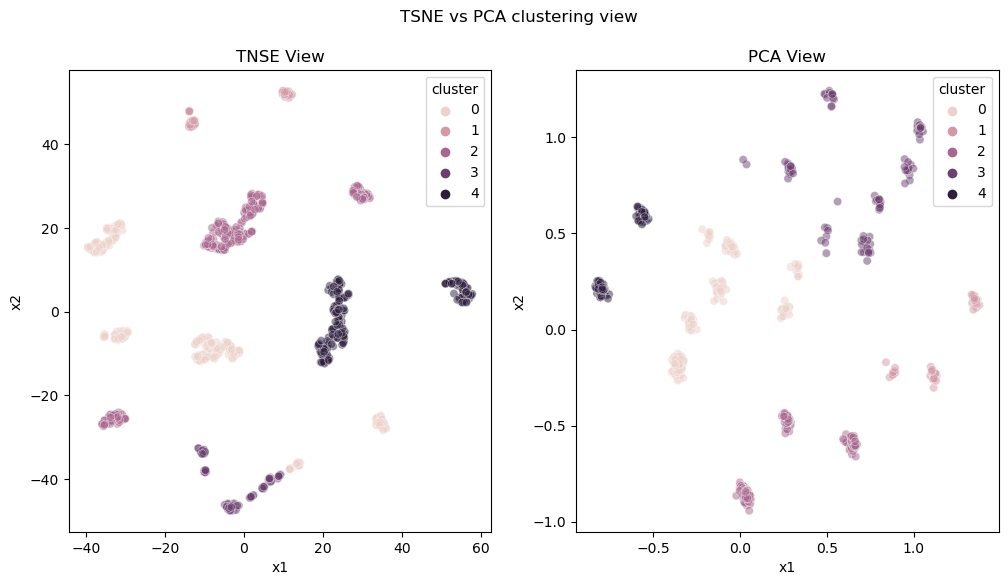

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('TNSE View')
sns.scatterplot(data=dfPCA,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
ax[1].set_title('PCA View')
fig.suptitle('TSNE vs PCA clustering view')

In [31]:
def out_limit(df, label_col, label, sensitivity):
    l_features = df.columns[:-1]
    
    l_plot = []
    l_mean_all = []
    l_mean_cls = []
    
    for i,var in enumerate(l_features):
        #get all-mean and set lower and upper limit
        mean_all = df[var].mean()
        btm_limit = mean_all - (mean_all*sensitivity)
        up_limit = mean_all + (mean_all*sensitivity)

        #get cluster-mean
        cls_filter = df[label_col]==label
        pd_cls = df[cls_filter]
        mean_cls = pd_cls[var].mean()
    
        #create filter for graph with 0.5 deviation fr mean
        if mean_cls <= btm_limit or mean_cls >= up_limit:
            l_plot.append(var)
            mean_all_std = mean_all/mean_all
            mean_cls_std = mean_cls/mean_all
            l_mean_all.append(mean_all_std)
            l_mean_cls.append(mean_cls_std)
   
    meandf = pd.DataFrame({'features':l_plot, 'mean_all':l_mean_all, 
                            'mean_clusters':l_mean_cls})
    meandf = meandf.sort_values(by=['mean_clusters'], ascending=False)
  
    return meandf

def plot_barchart(df, labelcol, label, ax, sensitivity):
    meandf = out_limit(df, labelcol, label, sensitivity)
    meandf_plot = meandf.drop(['mean_all'], axis=1)
  
    if len(meandf.index) != 0:
        sns.barplot(y='features', x='mean_clusters', data=meandf_plot, 
                    palette=sns.cubehelix_palette(10, hue=1, start=.5, rot=-.75, reverse=True), dodge=True, ax=ax)

    for i,p in enumerate(ax.patches):
        ax.annotate("{:.02f}".format((p.get_width())), (1, p.get_y() + p.get_height() / 2.), 
                    xycoords=('axes fraction', 'data'), ha='right', va='top', fontsize=9, color='purple', rotation=0,
                    xytext=(0, 0), textcoords='offset pixels')
    
    ax.set_title(f'Unique characteristics (Cluster {label})')
    ax.set_xlabel('Standardized Mean')
    ax.axvline(x=1, color='k')

def plot_cluster(df, labelcol, nclusters, sensitivity):
    nplot = nclusters
    fig, ax = plt.subplots(nplot, 1, figsize=(7, nplot*3), sharex='col')
    ax= ax.ravel()
    
    label = np.arange(nclusters)
    for i in label:
        plot_barchart(df, labelcol, label=i, ax=ax[i], sensitivity=sensitivity)
        ax[i].xaxis.set_tick_params(labelbottom=True)
    
    plt.tight_layout()

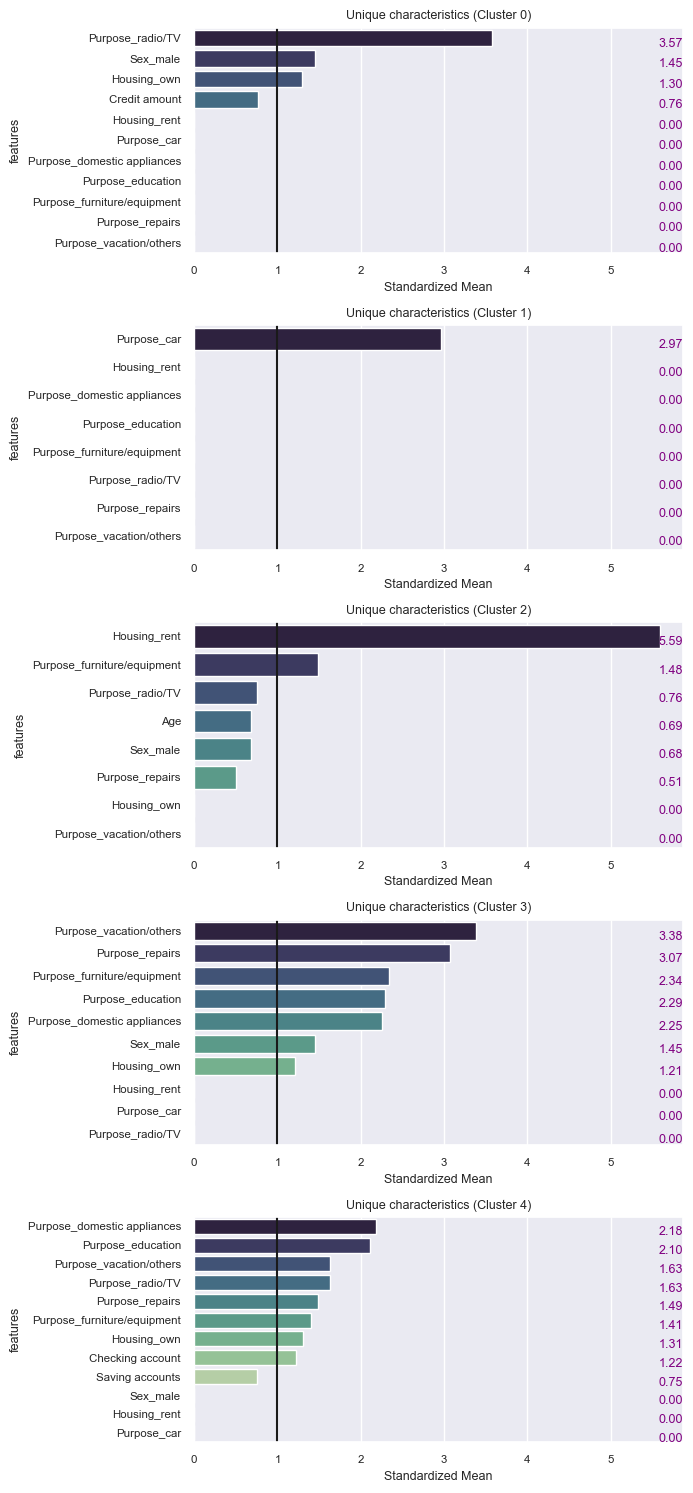

In [32]:
sns.set(font_scale=.75)
kmeans = KMeans(n_clusters=5)
clustering_ori = kmeans.fit_predict(data_scaled)
data_scaled['cluster'] = clustering_ori
plot_cluster(df=data_scaled, labelcol='cluster', nclusters=5, sensitivity=0.2)